In [19]:
IS_KAGGLE = True

In [20]:
import pandas as pd
from pathlib import Path
from typing import Dict, List
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np

In [21]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

In [22]:
if IS_KAGGLE:
    df: pd.DataFrame = pd.read_parquet("/kaggle/input/dataset-sharechat/train_valEncoded.parquet")
        
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    recsys = user_secrets.get_secret("recsys")
    !git clone https://{recsys}@github.com/Benedart/Recsys-Challenge-2023.git
        
    import os
    os.chdir( "./Recsys-Challenge-2023")
else:
    TRAIN_VAL_DATA_PATH = 'data/train_val.parquet'
    df: pd.DataFrame = pd.read_parquet(TRAIN_VAL_DATA_PATH) 

df = df.astype({f"f_{i}": "category" for i in range(2, 33)})

Cloning into 'Recsys-Challenge-2023'...
remote: Enumerating objects: 1112, done.
remote: Counting objects: 100% (411/411), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 1112 (delta 261), reused 342 (delta 199), pack-reused 701
Receiving objects: 100% (1112/1112), 19.54 MiB | 28.51 MiB/s, done.
Resolving deltas: 100% (661/661), done.


In [23]:
from utils.normalized_cross_entropy_loss import normalized_cross_entropy_loss

In [24]:
features = []
for x in range(1,80):
    features.append("f_{}".format(x))

features

['f_1',
 'f_2',
 'f_3',
 'f_4',
 'f_5',
 'f_6',
 'f_7',
 'f_8',
 'f_9',
 'f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_27',
 'f_28',
 'f_29',
 'f_30',
 'f_31',
 'f_32',
 'f_33',
 'f_34',
 'f_35',
 'f_36',
 'f_37',
 'f_38',
 'f_39',
 'f_40',
 'f_41',
 'f_42',
 'f_43',
 'f_44',
 'f_45',
 'f_46',
 'f_47',
 'f_48',
 'f_49',
 'f_50',
 'f_51',
 'f_52',
 'f_53',
 'f_54',
 'f_55',
 'f_56',
 'f_57',
 'f_58',
 'f_59',
 'f_60',
 'f_61',
 'f_62',
 'f_63',
 'f_64',
 'f_65',
 'f_66',
 'f_67',
 'f_68',
 'f_69',
 'f_70',
 'f_71',
 'f_72',
 'f_73',
 'f_74',
 'f_75',
 'f_76',
 'f_77',
 'f_78',
 'f_79']

In [25]:
for f in features:
    if df[f].isna().sum() > 0:
        mean = df[f].mean()
        df[f].fillna(value=mean, inplace=True)
df

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,is_clicked,is_installed
0,2541162,51,29,4,123,4,2334,0,0,6,...,3.997850,1.713364,0.115692,1.156922,0.269948,0.0,0.0,0.0,False,False
1,2541260,49,87,0,451,0,3625,0,4,0,...,0.000000,0.000000,0.115692,1.156922,0.269948,0.0,0.0,0.0,False,False
2,2541318,51,87,0,451,4,3625,0,4,6,...,0.000000,0.000000,0.038564,1.156922,0.269948,0.0,0.0,0.0,False,False
3,2541770,64,57,4,148,4,4793,0,4,4,...,1.713364,1.142243,0.115692,1.156922,0.269948,0.0,0.0,0.0,False,False
4,2542002,62,87,0,614,0,100,0,0,5,...,0.000000,0.000000,0.115692,1.156922,0.269948,0.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485847,1988041,62,55,4,56,4,2934,0,4,5,...,0.000000,0.000000,0.000000,0.231384,0.000000,0.0,0.0,0.0,False,False
3485848,1988471,45,117,4,235,3,4169,0,1,1,...,1.142243,0.000000,0.000000,1.156922,0.269948,0.0,0.0,0.0,False,False
3485849,1988651,56,114,4,191,4,155,0,4,0,...,1.142243,0.000000,0.115692,1.156922,0.269948,0.0,0.0,0.0,False,False
3485850,1988792,48,135,4,136,2,1488,0,1,5,...,2.284486,1.713364,0.000000,1.156922,0.269948,0.0,0.0,0.0,False,False


In [26]:
np.sort(df["f_1"].unique())

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66], dtype=object)

--------

In [27]:
df = df.astype({'f_1': 'int'})

booleans = range(33, 41+1)
for i in booleans:
    df = df.astype({'f_{}'.format(i): 'int'})

df = df.astype({'is_clicked': 'int'})
df = df.astype({'is_installed': 'int'})

In [28]:
train_days = range(45, 63)
val_days = range(63, 67)
train_days, val_days

(range(45, 63), range(63, 67))

In [29]:
threshold_day = 63

In [30]:
X_train = df[df["f_1"]<threshold_day].drop(columns=['is_clicked','is_installed'])
y_train = df[df["f_1"]<threshold_day]
y_train = y_train[['is_installed']]

X_val = df[df["f_1"]>=threshold_day].drop(columns=['is_clicked','is_installed'])
y_val = df[df["f_1"]>=threshold_day]
y_val = y_val[['is_installed']]

In [31]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2967905, 80), (2967905, 1), (517947, 80), (517947, 1))

### Preprocessing

In [32]:
to_delete = ['f_0','f_7','f_27','f_28','f_29']
X_train = X_train.drop(columns=to_delete)
X_val = X_val.drop(columns=to_delete)

## Training with focal loss

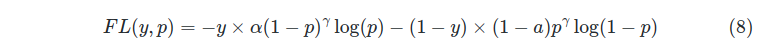

In [33]:
from scipy import optimize
from scipy import special

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better

In [34]:
import lightgbm as lgb

### With the default parameters the focal loss becomes the cross entropy

In [35]:
fl = FocalLoss(alpha=None, gamma=0)

In [36]:
y_train

,is_installed
0,0
1,0
2,0
4,0
6,0
...,...
3485846,0
3485847,0
3485848,0
3485849,0


In [37]:
train = lgb.Dataset(
    X_train, y_train,
    init_score=np.full_like(y_train, fl.init_score(y_train), dtype=float)
)

In [38]:
val = lgb.Dataset(
    X_val, y_val,
    init_score=np.full_like(y_val, fl.init_score(y_train), dtype=float),
    reference=train
)

In [39]:
light_params= {
    'task': 'train',
  'boosting_type': 'gbdt',
  'objective': 'binary',
    'learning_rate': 0.025199403190325702,
  'max_depth': 284,
  'num_leaves': 53
  }

In [40]:
gbm_installed = lgb.train(
    params=light_params,
    train_set=train,
    num_boost_round=10000,
    valid_sets=(train, val),
    valid_names=('train', 'val'),
    early_stopping_rounds=20,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.682926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8807
[LightGBM] [Info] Number of data points in the train set: 2967905, number of used features: 75


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 20 rounds
[100]	train's focal_loss: 0.270788	val's focal_loss: 0.361746
[200]	train's focal_loss: 0.255037	val's focal_loss: 0.351528
[300]	train's focal_loss: 0.247953	val's focal_loss: 0.34851
[400]	train's focal_loss: 0.243274	val's focal_loss: 0.347511
Early stopping, best iteration is:
[466]	train's focal_loss: 0.240883	val's focal_loss: 0.347378


### Evaluation

In [41]:
results_installed = special.expit(fl.init_score(y_val) + gbm_installed.predict(X_val))
predictions_installed = (results_installed > 0.5).astype(int)

results_installed, predictions_installed, np.sum(predictions_installed)

(array([0.05894488, 0.47768037, 0.01328264, ..., 0.16933739, 0.17342139,
        0.32143805]),
 array([0, 0, 0, ..., 0, 0, 0]),
 17723)

In [42]:
positive_rate = 3
print("entropy: {}".format(normalized_cross_entropy_loss(results_installed, y_val["is_installed"], positive_rate)))

entropy: 0.34981833474383384


In [43]:
cf = confusion_matrix(y_val["is_installed"], predictions_installed)
cf

array([[427614,   6706],
       [ 72610,  11017]])

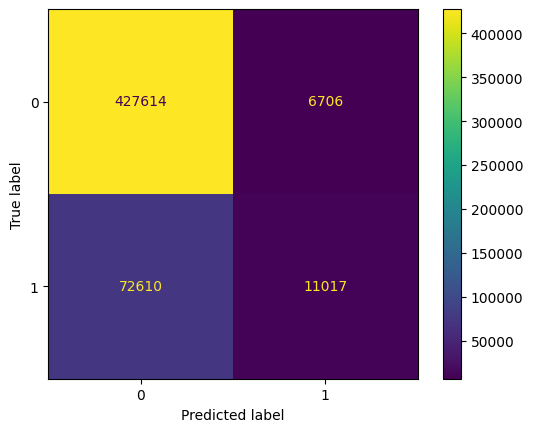

In [44]:
cf = np.matrix([
    [cf[0,0], cf[0,1]],
    [cf[1,0], cf[1,1]]
    ])
ConfusionMatrixDisplay(confusion_matrix=cf).plot()

-----------------

# Let's try some different values of \alpha and \gamma

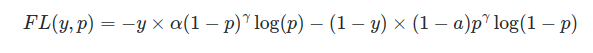

#### These are the parameters after 60 trials optimizing for cross entropy

In [45]:
light_params= {
  'task': 'train',
  'boosting_type': 'gbdt',
  'learning_rate': 0.027599133933890175,
  'max_depth': 189,
  'num_leaves': 253
  }

In [46]:
alpha = 0.5646234402091014
gamma = 0.05631742332144237

In [47]:
fl = FocalLoss(alpha=alpha, gamma=gamma)

In [48]:
train = lgb.Dataset(
    X_train, y_train,
    init_score=np.full_like(y_train, fl.init_score(y_train), dtype=float)
)

In [49]:
val = lgb.Dataset(
    X_val, y_val,
    init_score=np.full_like(y_val, fl.init_score(y_train), dtype=float),
    reference=train
)

In [50]:
gbm_installed = lgb.train(
    params=light_params,
    train_set=train,
    num_boost_round=10000,
    valid_sets=(train, val),
    valid_names=('train', 'val'),
    early_stopping_rounds=20,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.680222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8807
[LightGBM] [Info] Number of data points in the train set: 2967905, number of used features: 75


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 20 rounds
[100]	train's focal_loss: 0.124055	val's focal_loss: 0.175038
[200]	train's focal_loss: 0.112913	val's focal_loss: 0.172267
Early stopping, best iteration is:
[254]	train's focal_loss: 0.109179	val's focal_loss: 0.171914


In [51]:
results_installed = special.expit(fl.init_score(y_val) + gbm_installed.predict(X_val))
predictions_installed = (results_installed > 0.5).astype(int)

results_installed, predictions_installed, np.sum(predictions_installed)

(array([0.05453915, 0.53784593, 0.01801868, ..., 0.13869292, 0.31006177,
        0.32908961]),
 array([0, 1, 0, ..., 0, 0, 0]),
 25757)

In [52]:
positive_rate = 3
print("entropy: {}".format(normalized_cross_entropy_loss(results_installed, y_val["is_installed"], positive_rate)))

entropy: 0.3470515420697052


In [53]:
cf = confusion_matrix(y_val["is_installed"], predictions_installed)
cf

array([[423889,  10431],
       [ 68301,  15326]])

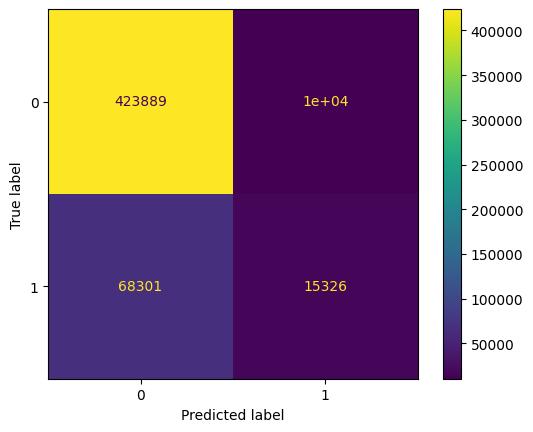

In [54]:
cf = np.matrix([
    [cf[0,0], cf[0,1]],
    [cf[1,0], cf[1,1]]
    ])
ConfusionMatrixDisplay(confusion_matrix=cf).plot()

----------------

For further info, refer to:

## [https://maxhalford.github.io/blog/lightgbm-focal-loss/](http://)